In [4]:
%load_ext autoreload
%autoreload 2

# Data

In [2]:
from src.data import (
    fetch_transactions,
    save_btyd_features,
    save_customer_data,
)

In [3]:
transactions = fetch_transactions()
save_btyd_features(transactions)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Fetched 2828790 transactions from /Users/anthonybeech/python/dsci/ltv/data/transactions.parquet
Saved BTYD features to /Users/anthonybeech/python/dsci/ltv/data/btyd_features.parquet
No of customers: 1336210


In [ ]:
save_customer_data()

In [7]:
import pandas as pd
from src.config import BTYD_FEATURES_DATASET, CUSTOMER_DATA_DATASET

df = pd.read_parquet(BTYD_FEATURES_DATASET)
df_customer = pd.read_parquet(CUSTOMER_DATA_DATASET)

* Frequency: Number of distinct time units (e.g. days or weeks) in which the customer made a purchase — not the total number of purchases.
* T (Customer Age): Time between the customer’s first purchase and the end of the observation period.
* Recency: Time between the customer’s first and most recent purchase (0 if only one purchase).
* Monetary Value: Average purchase value = total spend / number of purchases (not based on frequency).

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335849 entries, 0 to 1335848
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype
---  ------           --------------    -----
 0   frequency        1335849 non-null  int32
 1   recency          1335849 non-null  int32
 2   T                1335849 non-null  int32
 3   monetary_value   1335849 non-null  int32
 4   days_since_last  1335849 non-null  int32
dtypes: int32(5)
memory usage: 25.5 MB


In [9]:
df.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]).round(0)

,frequency,recency,T,monetary_value,days_since_last
count,1335849.0,1335849.0,1335849.0,1335849.0,1335849.0
mean,1.0,235.0,1213.0,197.0,977.0
std,5.0,565.0,980.0,518.0,903.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,454.0,0.0,276.0
50%,0.0,0.0,966.0,0.0,713.0
75%,1.0,104.0,1726.0,191.0,1425.0
90%,3.0,869.0,2603.0,626.0,2283.0
99%,13.0,2751.0,4278.0,2215.0,4009.0
max,1565.0,9347.0,9376.0,58806.0,9376.0


array([[<Axes: title={'center': 'frequency'}>,
        <Axes: title={'center': 'recency'}>],
       [<Axes: title={'center': 'T'}>,
        <Axes: title={'center': 'monetary_value'}>],
       [<Axes: title={'center': 'days_since_last'}>, <Axes: >]],
      dtype=object)

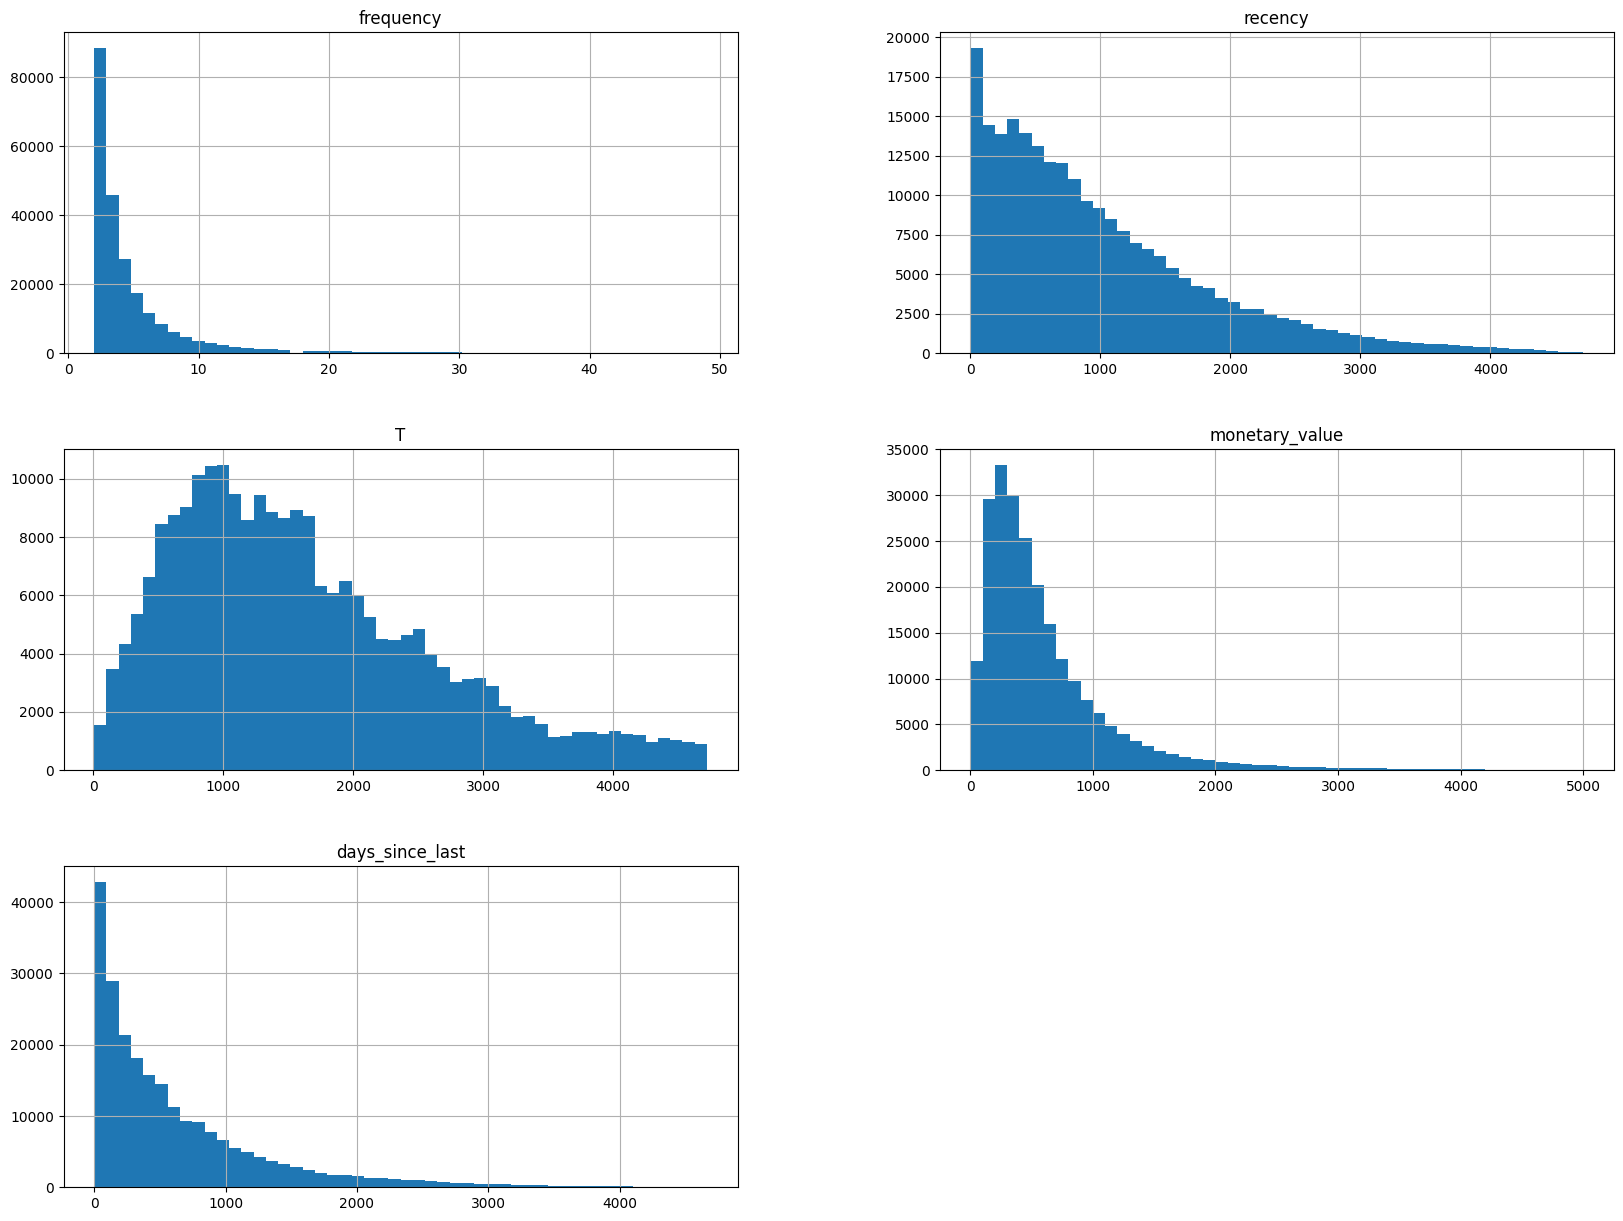

In [10]:
df[
    (df["frequency"] > 1)
    & (df["frequency"] < 50)
    & (df["recency"] < 5000)
    & (df["T"] < 5000)
    & (df["monetary_value"] < 5000)
].hist(bins=50, figsize=(20, 15))

In [11]:
df_customer.describe().round(0)

,customer_id,customer_three_year_gmv_lttv_gbp,customer_three_year_sell_value_lttv_gbp,buy_rfm_score,sell_rfm_score,days_to_second_transaction,is_active_customer,is_active_buyer,is_active_seller,is_habitual_customer,is_habitual_buyer,is_habitual_seller,customer_all_time_gmv_gbp,customer_all_time_sell_value_gbp,total_completed_transactions,total_buy_transactions,total_sell_transactions,sessions,sessions_perc_organic,days_active,months_active,sessions_perc_mobile,sessions_sell_form,sessions_model_page_view,total_product_page_views,session_recency,sell_form_recency,product_page_recency,total_active_browsing_time_milliseconds,total_items_sold,avg_items_sold_per_txn,mirrorless_items_sold,dslr_items_sold,compact_items_sold,cameras_sold,lenses_sold,cine_kit_sold,total_items_bought,avg_items_bought_per_txn,mirrorless_items_bought,dslr_items_bought,compact_items_bought,cameras_bought,lenses_bought,cine_kit_bought
count,1335849.0,479005.0,230846.0,1083494.0,491271.0,460412.0,1335849.0,1335849.0,1335849.0,1335849.0,1335849.0,1335849.0,1083899.0,491433.0,1335849.0,1335849.0,1335849.0,456788.0,456788.0,456788.0,456788.0,456788.0,456788.0,456788.0,456788.0,456788.0,275044.0,372888.0,4.567880e+05,491371.0,491371.0,491371.0,491371.0,491371.0,491371.0,491371.0,491371.0,1083525.0,1083525.0,1083525.0,1083525.0,1083525.0,1083525.0,1083525.0,1083525.0
mean,2454077.0,873.0,1268.0,20.0,24.0,303.0,0.0,0.0,0.0,0.0,0.0,0.0,929.0,1342.0,2.0,2.0,1.0,25.0,0.0,13.0,3.0,1.0,2.0,11.0,28.0,135.0,150.0,142.0,2.836538e+06,5.0,1.0,2.0,2.0,0.0,1.0,3.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
std,1008626.0,4615.0,3074.0,12.0,17.0,469.0,0.0,0.0,0.0,0.0,0.0,0.0,6565.0,3855.0,6.0,5.0,2.0,63.0,0.0,24.0,3.0,0.0,8.0,32.0,95.0,108.0,105.0,107.0,9.011070e+06,12.0,1.0,5.0,5.0,1.0,3.0,6.0,1.0,34.0,0.0,5.0,29.0,1.0,9.0,24.0,0.0
min,812085.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000000e+00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1555093.0,158.0,204.0,12.0,14.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,168.0,210.0,1.0,1.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,37.0,56.0,45.0,3.642840e+05,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,2446950.0,375.0,493.0,19.0,22.0,111.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,496.0,1.0,1.0,0.0,9.0,0.0,6.0,2.0,1.0,1.0,3.0,6.0,112.0,135.0,125.0,9.540380e+05,3.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
75%,3278002.0,898.0,1260.0,25.0,28.0,385.0,1.0,0.0,0.0,0.0,0.0,0.0,925.0,1232.0,2.0,2.0,1.0,23.0,0.0,14.0,4.0,1.0,3.0,9.0,22.0,220.0,234.0,227.0,2.481413e+06,6.0,2.0,2.0,3.0,0.0,1.0,3.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
max,4355888.0,2194133.0,329496.0,100.0,100.0,6674.0,1.0,1.0,1.0,1.0,1.0,1.0,4006223.0,502781.0,2394.0,2394.0,504.0,6214.0,1.0,366.0,14.0,1.0,1095.0,1774.0,14552.0,367.0,367.0,367.0,1.470793e+09,1709.0,87.0,645.0,1027.0,132.0,594.0,931.0,439.0,24926.0,41.0,2335.0,23050.0,461.0,7338.0,17451.0,95.0


array([[<Axes: title={'center': 'customer_id'}>,
        <Axes: title={'center': 'customer_three_year_gmv_lttv_gbp'}>,
        <Axes: title={'center': 'customer_three_year_sell_value_lttv_gbp'}>,
        <Axes: title={'center': 'buy_rfm_score'}>,
        <Axes: title={'center': 'sell_rfm_score'}>,
        <Axes: title={'center': 'days_to_second_transaction'}>,
        <Axes: title={'center': 'is_active_customer'}>],
       [<Axes: title={'center': 'is_active_buyer'}>,
        <Axes: title={'center': 'is_active_seller'}>,
        <Axes: title={'center': 'is_habitual_customer'}>,
        <Axes: title={'center': 'is_habitual_buyer'}>,
        <Axes: title={'center': 'is_habitual_seller'}>,
        <Axes: title={'center': 'customer_all_time_gmv_gbp'}>,
        <Axes: title={'center': 'customer_all_time_sell_value_gbp'}>],
       [<Axes: title={'center': 'total_completed_transactions'}>,
        <Axes: title={'center': 'total_buy_transactions'}>,
        <Axes: title={'center': 'total_sell_

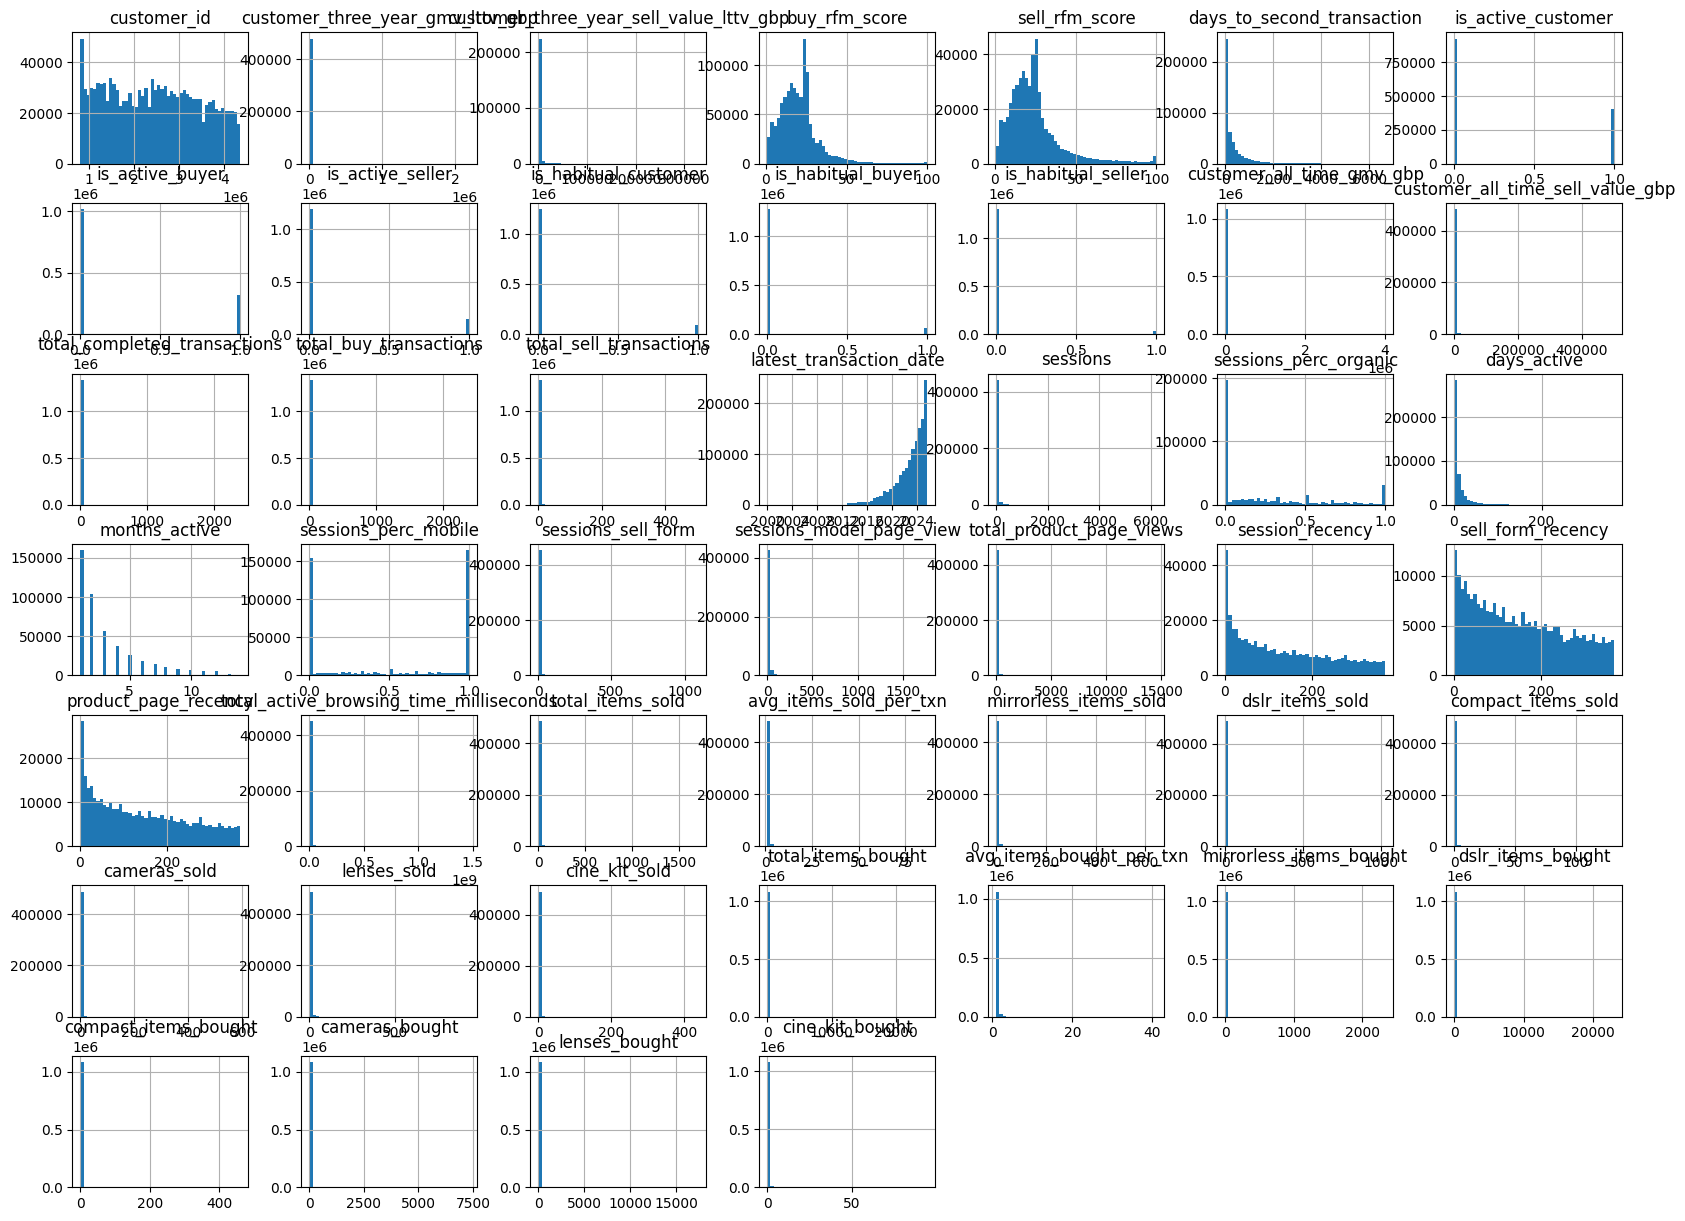

In [12]:
df_customer.hist(bins=50, figsize=(20, 15))

# Modelling

In [4]:
import pandas as pd
from src.config import BTYD_FEATURES_DATASET, CUSTOMER_DATA_DATASET

df = pd.read_parquet(BTYD_FEATURES_DATASET)
df_customer = pd.read_parquet(CUSTOMER_DATA_DATASET)

In [5]:
_df = df[(df["frequency"] < 100) & (df["recency"] < 5000) & (df["T"] < 5000)].sample(
    n=10000, random_state=42
)

In [6]:
from src.model import (
    BaseModel,
    BGNBD,
    ParetoNBD,
    Empirical,
    BGNBDEmpiricalSingle,
    BGNBDEmpiricalSingleTrainNoSingle,
    ParetoEmpiricalSingleTrainNoSingle,
)

models: list[BaseModel] = [
    BGNBD(),
    ParetoNBD(),
    Empirical(),
    BGNBDEmpiricalSingle(),
    BGNBDEmpiricalSingleTrainNoSingle(),
    ParetoEmpiricalSingleTrainNoSingle(),
]

for model in models:
    print(f"Fitting {model.name}")
    model.fit(_df)
    _df[f"{model.name}_p_alive"] = model.p_alive(_df)
    _df[f"{model.name}_status"] = model.customer_status(_df)
    _df[f"{model.name}_future_transactions"] = model.predict_future_transactions(
        _df, 365 * 5
    )

Fitting BGNBD
Fitting ParetoNBD
Fitting Empirical_270_540
Fitting BGNBDES_270_540
Fitting BGNBDESTNS_270_540
Fitting ParetoESTNS_270_540


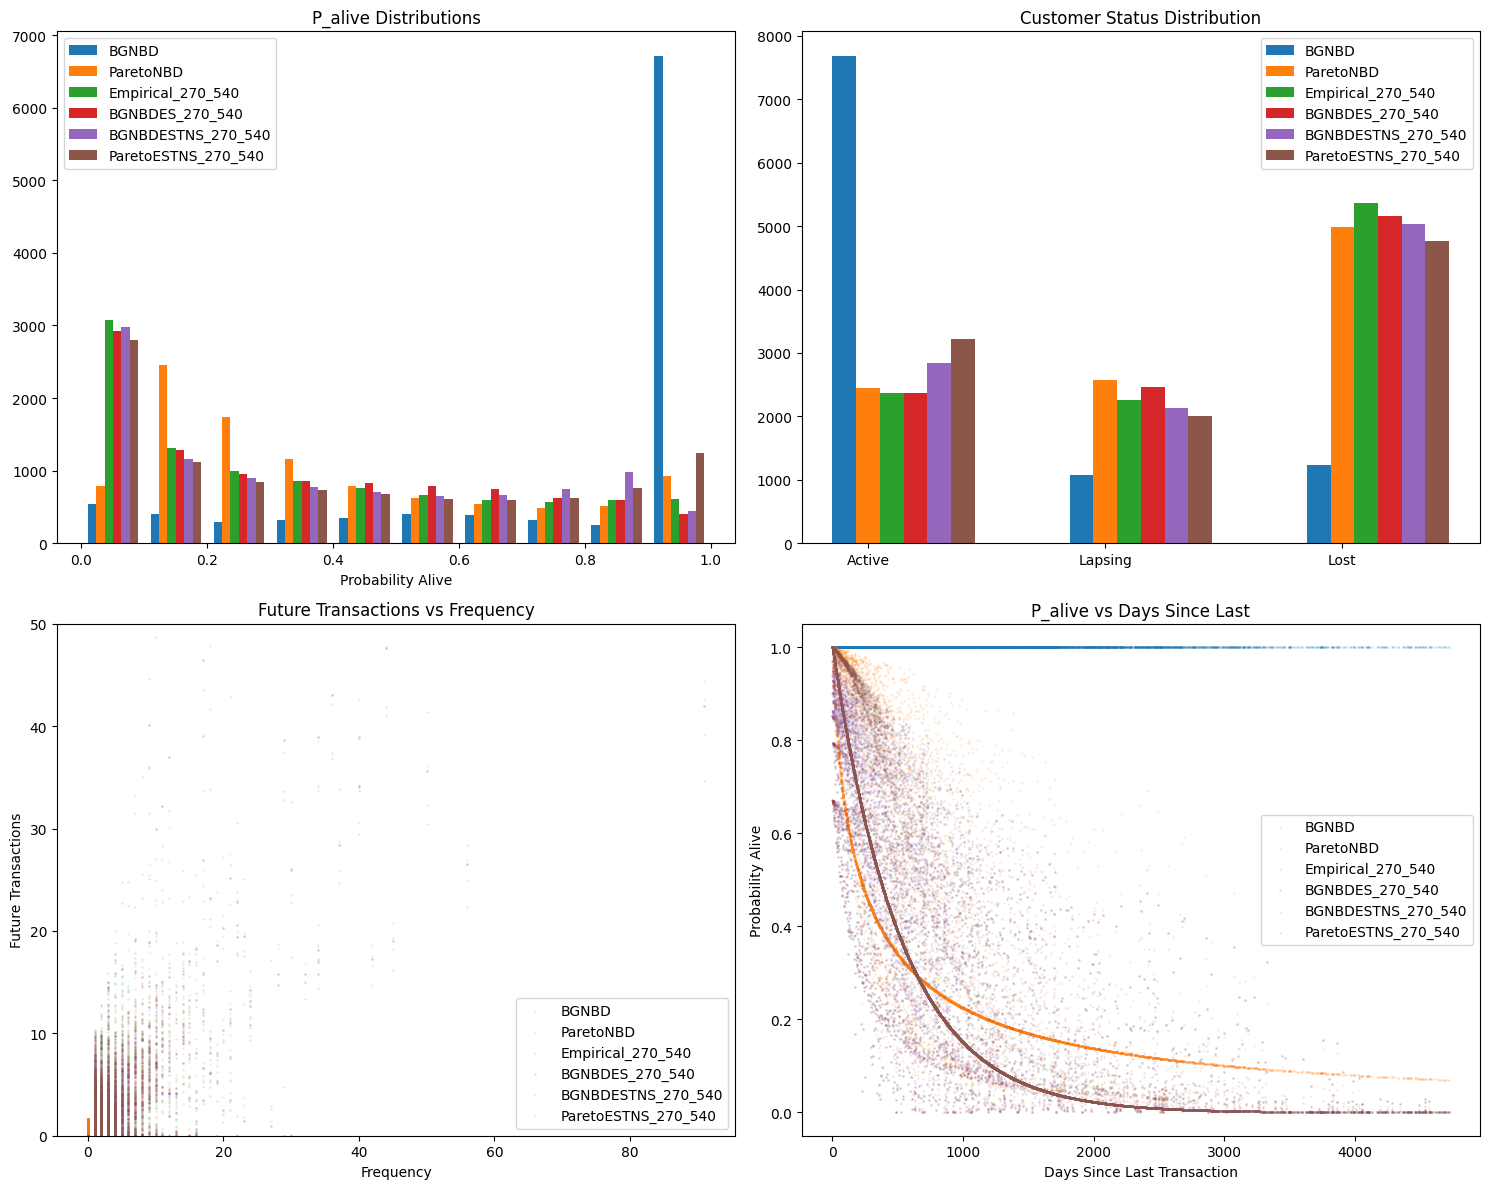

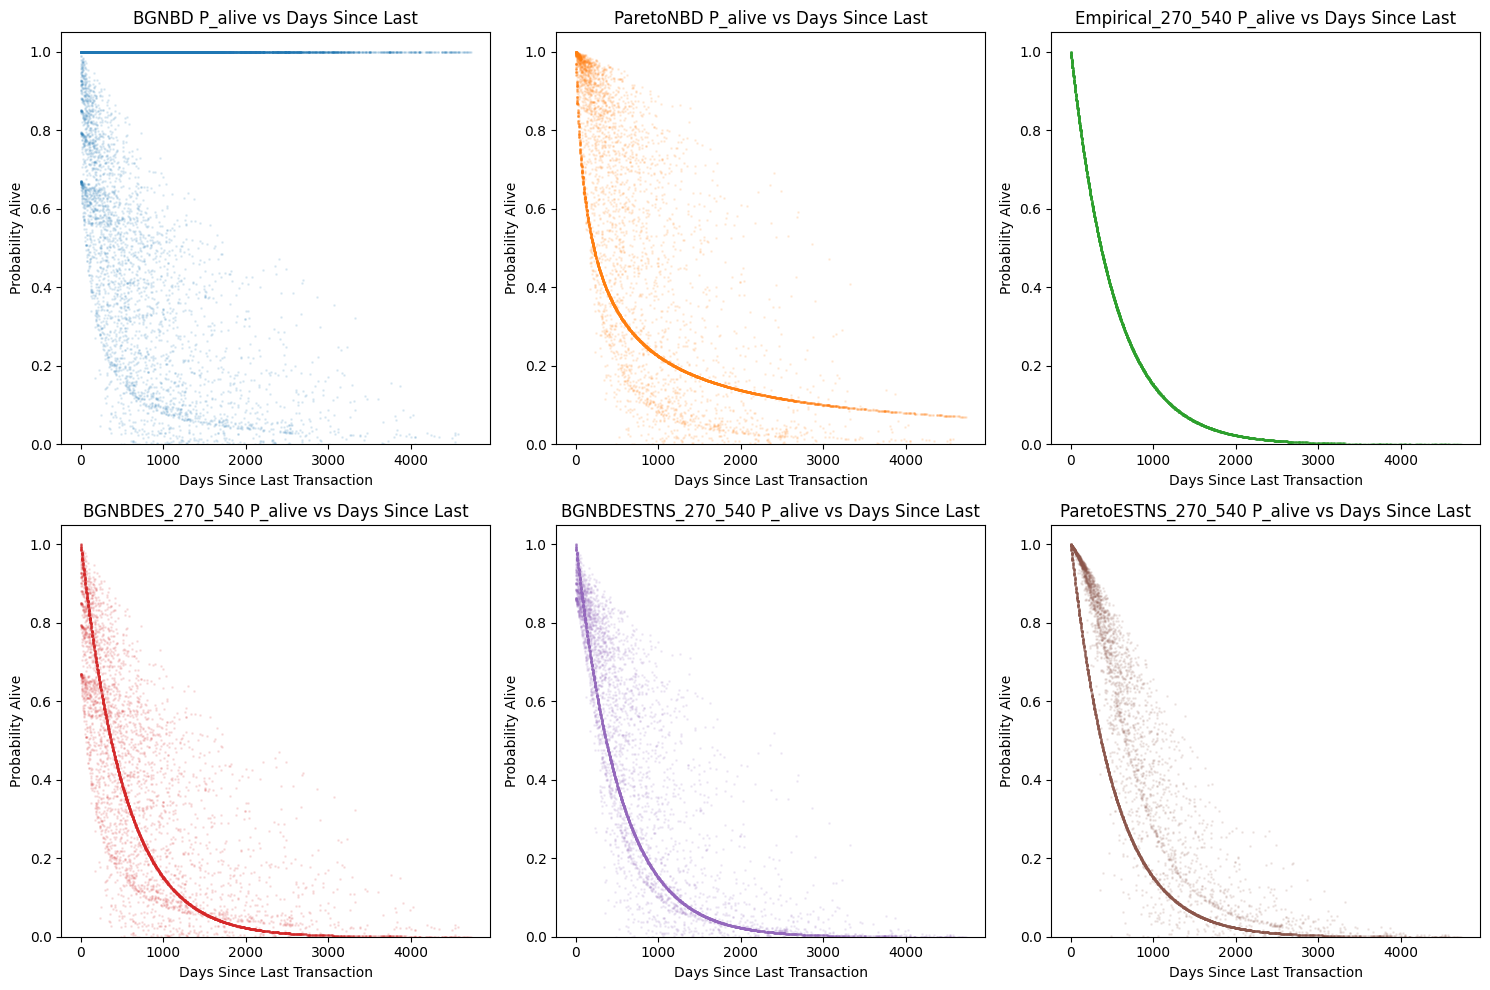

,Model,Avg P_alive,P_alive Std,Active %,Lapsing %,Lost %,Avg Future Txns
0,BGNBD,0.807099,0.313149,76.87,10.75,12.38,0.945907
1,ParetoNBD,0.397012,0.281989,24.46,25.71,49.83,1.092621
2,Empirical_270_540,0.344055,0.303317,23.68,22.65,53.67,1.012500
3,BGNBDES_270_540,0.347132,0.292341,23.66,24.68,51.66,0.704101
4,BGNBDESTNS_270_540,0.368771,0.311360,28.38,21.26,50.36,0.938784
5,ParetoESTNS_270_540,0.406317,0.338793,32.24,20.10,47.66,1.147680


In [7]:
from src.eval import evaluate_models

evaluate_models(_df)

# Writing to BQ

In [8]:
_df.columns

Index(['customer_id', 'frequency', 'recency', 'T', 'monetary_value',
       'days_since_last', 'BGNBD_p_alive', 'BGNBD_status',
       'BGNBD_future_transactions', 'ParetoNBD_p_alive', 'ParetoNBD_status',
       'ParetoNBD_future_transactions', 'Empirical_270_540_p_alive',
       'Empirical_270_540_status', 'Empirical_270_540_future_transactions',
       'BGNBDES_270_540_p_alive', 'BGNBDES_270_540_status',
       'BGNBDES_270_540_future_transactions', 'BGNBDESTNS_270_540_p_alive',
       'BGNBDESTNS_270_540_status', 'BGNBDESTNS_270_540_future_transactions',
       'ParetoESTNS_270_540_p_alive', 'ParetoESTNS_270_540_status',
       'ParetoESTNS_270_540_future_transactions'],
      dtype='object')

In [9]:
# Join df_customer with df_model_predictions
df_combined = df_customer.merge(_df, on="customer_id", how="left")

In [11]:
from src.utils.bq import BQ
bq = BQ()

bq.to_bq(df_combined, "mpb-data-science-dev-ab-602d.sandbox.customer_ltv_analysis")

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
